In [1]:
import numpy as np
import torch
import copy
import pandas as pd
import SimpleITK as sitk
from PIL import Image
# import pydicom
import cv2
import nibabel as nib
import os
import skimage.io as io

import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
# from func.model_arch import SegAirwayModel

from sklearn.manifold import TSNE

import random
import h5py

from torch import from_numpy as from_numpy

from active_learning_utils import save_obj,load_obj,show_all_2d_img_with_labels
import torchio as tio

import sys
sys.path.append('../')  # 将上一层目录添加到模块搜索路径中
from func.model_arch2 import SegAirwayModel

In [2]:
al_20=load_obj('/home/wangc/now/NaviAirway/saved_objs/for_256_objs/training_info/al_20_dict.pkl')

In [16]:
al_indexs1=[i for i in list(al_20.keys()) if i[:3]=='EXA']
al_indexs2=[i for i in list(al_20.keys()) if i[:3]=='LID']

In [18]:
crop_size=['128','256']
file_insert=crop_size[1]
Precrop_dataset_for_train_path = f"/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_{file_insert}"
Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"

raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
# print(len(raw_case_name_list))

lidc_dataset_for_train_path=f'/mnt/wangc/LIDC/Precrop_dataset_for_LIDC-IDRI_{file_insert}'
lidc_dataset_for_train_raw_path =lidc_dataset_for_train_path+"/image"
lidc_dataset_for_train_label_path = lidc_dataset_for_train_path+"/label"
lidc_raw_case_name_list = os.listdir(lidc_dataset_for_train_raw_path)

In [19]:
output_folder='/home/wangc/now/NaviAirway/saved_picture/for_256_cluster/test_num'

In [20]:
show_all_2d_img_with_labels(Precrop_dataset_for_train_raw_path, output_folder=output_folder, img_num=10000, num_images_per_batch=16, slice_index=20, label_path=Precrop_dataset_for_train_label_path,raw_img_list=al_indexs1,file_name='al_exact')
show_all_2d_img_with_labels(lidc_dataset_for_train_raw_path, output_folder=output_folder, img_num=10000, num_images_per_batch=16, slice_index=20, label_path=lidc_dataset_for_train_label_path,raw_img_list=al_indexs2,file_name='al_exact')

In [16]:
import os
import matplotlib.pyplot as plt
from skimage import io

def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None):
    raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)
            print(f'img_selecting {100 * (i+1) / img_num:.2f}%', end='\r')
        
        # 创建一个包含16个子图的图像窗口
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = axes[i, j]
                    
                    # ax.imshow(raw_img[slice_index, :, :], cmap='gray')
                    
                    if label_path is not None:
                        label_img_addr = os.path.join(label_path, raw_img_list[index])
                        label_img = io.imread(label_img_addr, plugin='simpleitk')
                        
                        # 将轮廓像素点改为红色
                    
                        if 1 not in label_img[slice_index, :, :]:
                            j=0
                            while(j<label_img.shape[0] and 1 not in label_img[j, :, :]):
                                j+=1
                            if j<label_img.shape[0]:
                                raw_img_with_contour = raw_img.copy()
                                raw_img_with_contour[j, :, :][label_img[j, :, :] == 1] = 255
                                ax.imshow(raw_img_with_contour[j, :, :], cmap='gray')
                            else:
                                raw_img_with_contour = raw_img.copy()
                                raw_img_with_contour[0, :, :][label_img[0, :, :] == 1] = 255
                                ax.imshow(raw_img_with_contour[0, :, :], cmap='gray')
                                ax.text(1, 1, 'No Label', color='red', fontsize=16, ha='right', va='top', transform=ax.transAxes)
                        else:
                            j=slice_index
                            raw_img_with_contour = raw_img.copy()
                            raw_img_with_contour[j, :, :][label_img[j, :, :] == 1] = 255
                            ax.imshow(raw_img_with_contour[j, :, :], cmap='gray')
                    else:
                        ax.imshow(raw_img[slice_index, :, :], cmap='gray')
                    # ax.set_title(f"Image {img_names[index]}\nLabel {label_names[index]} ")
                    ax.axis('off')
               
        # 调整子图之间的间距和布局
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"label_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()


In [ ]:
def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None,raw_img_list=None):
    if raw_img_list is None:
        raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        label_list = []  # 新增：用于存储标签图像

        img_names=[]
        label_names=[]
        
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)

            img_names.append(raw_img_list[i])
            
            if label_path is not None:
                if raw_img_list is None:
                    label_img_list = os.listdir(label_path)
                else:
                    label_img_list=raw_img_list
                label_img_addr = os.path.join(label_path, label_img_list[i])  # 使用相同的索引加载标签图像
                label_img = io.imread(label_img_addr, plugin='simpleitk')
                label_list.append(label_img)  # 存储标签图像

                label_names.append(label_img_list[i])
        
        # 创建一个包含16个子图的图像窗口，使用gridspec布局
        fig = plt.figure(figsize=(20, 20))
        gs = gridspec.GridSpec(num_rows, num_cols, figure=fig)
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = fig.add_subplot(gs[i, j])
                    if label_path is not None:
                        label_img = label_list[index]  # 使用相应索引的标签图像
                        if 1 not in label_img[slice_index, :, :]:
                            p=0
                            while(p<label_img.shape[0] and 1 not in label_img[p, :, :]):
                                p+=1
                            if p<label_img.shape[0]:
                                ax.imshow(raw_img[p, :, :], cmap='gray')
                                ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                            else:
                                p=0
                                ax.imshow(raw_img[p, :, :], cmap='gray')
                                ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                                ax.text(1, 1, 'No Label', color='red', fontsize=16, ha='right', va='top', transform=ax.transAxes)
                        else:
                            p=slice_index
                            ax.imshow(raw_img[p, :, :], cmap='gray')
                            ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                    else:
                        p=slice_index
                        ax.imshow(raw_img[p, :, :], cmap='gray')
                    ax.set_title(f"{p} Image {img_names[index]}\nLabel {label_names[index]} ")
                    ax.axis('off')
               
        # 调整子图之间的间距和布局
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"exact09_cluster_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()


In [63]:
Precrop_dataset_for_train_path = "//mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_256"
Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"
raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
# output_addr='/home/wangc/now/cluster_folder/exact09_256'

lidc_dataset_for_train_path='/mnt/wangc/LIDC/Precrop_dataset_for_LIDC-IDRI_128'
lidc_dataset_for_train_raw_path =lidc_dataset_for_train_path+"/image"
lidc_dataset_for_train_label_path = lidc_dataset_for_train_path+"/label"
output_addr='/home/wangc/now/cluster_folder/lidc128'

lidc_raw_case_name_list = os.listdir(lidc_dataset_for_train_raw_path)
show_all_2d_img_with_labels(raw_img_path=lidc_dataset_for_train_raw_path, output_folder=output_addr, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=lidc_dataset_for_train_label_path)

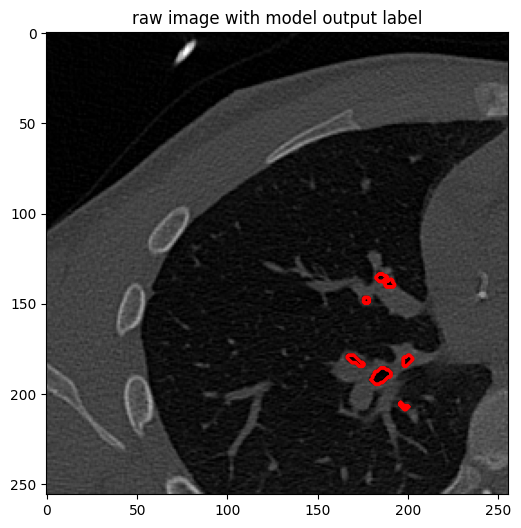

In [ ]:
import os
import matplotlib.pyplot as plt
from skimage import io

test_img = '/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_256/image/EXACT09_CASE01_68.nii.gz'
test_label = '/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_256/label/EXACT09_CASE01_68.nii.gz'
img = io.imread(test_img, plugin='simpleitk')
label = io.imread(test_label, plugin='simpleitk')
N = 10

# ----------

plt.figure(figsize=(8, 6))
plt.title("raw image with model output label")
ax = plt.gca()  # 获取当前的ax对象
ax.contour(label[N, :, :], colors='r', linestyles='-')
plt.imshow(img[N, :, :], cmap='gray')

plt.show()
